# **ENTRENAMIENTO DEL MODELO PARA DETECCIÓN DE VIOLENCIA FÍSICA - TimeSformer**

# **1. Configuración Inicial y Preparación**

In [1]:
# Instalación de dependencias
# !pip install transformers==4.36.0
!pip install transformers
!pip install torch torchvision
!pip install scikit-learn
!pip install wandb
!pip install decord
!pip install einops
!pip install timm
!pip install seaborn
!pip install tqdm
!pip install pytorch-grad-cam  # Para Grad-CAM
!pip install onnx  # Para exportación a ONNX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [8]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-w462jujx
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-w462jujx
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43669 sha256=2e3bf14c2a8c0510be70304c4eb85aaad1e7508ec732532f1566ac8037adba4a
  Stored in directory: /tmp/pip-ephem-wheel-cache-gh_ea5dv/wheels/a0/4d/c8/0502c44e32030c99ffab1b98075308a1ef9829c1835537afc6
Successfully built grad-cam
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [grad-cam]


In [9]:
# Importar librerías
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import random
import wandb
import glob
import math
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
import decord
from decord import VideoReader, cpu
from einops import rearrange
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import onnx
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Configuración de rutas
BASE_PATH = '/content/drive/MyDrive/Proyecto IA-3/violence_school_project'
DATASET_PATH = f'{BASE_PATH}/dataset_violencia'
MODELS_PATH = f'{BASE_PATH}/modelos/timesformer'
CHECKPOINTS_PATH = f'{BASE_PATH}/checkpoints/timesformer'
RESULTS_PATH = f'{BASE_PATH}/results/timesformer'
LOGGS_PATH = f'{BASE_PATH}/logs/timesformer'

# Crear directorios
for path in [MODELS_PATH, CHECKPOINTS_PATH, RESULTS_PATH, LOGGS_PATH]:
    os.makedirs(path, exist_ok=True)

# Configuración de semillas para reproducibilidad
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(42)

# Verificar GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory Available: 15.83 GB


# **2. Análisis y Visualización del Dataset**

In [12]:
# Configuración de clases
CLASS_NAMES = ['no_violencia', 'amenazante_ambigua', 'violencia_directa']
NUM_CLASSES = len(CLASS_NAMES)

# Dataset personalizado para videos
class ViolenceVideoDataset(Dataset):
    def __init__(self, root_dir, split='train', num_frames=8, transform=None):
        self.root_dir = Path(root_dir) / split
        self.num_frames = num_frames
        self.transform = transform
        self.classes = CLASS_NAMES
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Cargar videos
        self.video_paths = []
        self.labels = []

        for class_idx, class_name in enumerate(self.classes):
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                for video_path in class_dir.glob('*.mp4'):
                    self.video_paths.append(str(video_path))
                    self.labels.append(class_idx)

        print(f"Loaded {len(self.video_paths)} videos for {split} split")

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        try:
            video_path = self.video_paths[idx]
            label = self.labels[idx]

            # Cargar video con manejo de errores
            vr = VideoReader(video_path, ctx=cpu(0))
            total_frames = len(vr)

            # Muestrear frames uniformemente
            if total_frames <= self.num_frames:
                frame_indices = list(range(total_frames))
                while len(frame_indices) < self.num_frames:
                    frame_indices.extend(frame_indices[:self.num_frames - len(frame_indices)])
            else:
                frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)

            # Obtener frames
            frames = vr.get_batch(frame_indices).asnumpy()

            # Convertir a formato [C, T, H, W]
            frames = rearrange(frames, 't h w c -> c t h w')
            frames = frames.astype(np.float32) / 255.0

            # Redimensionar a 224x224
            if frames.shape[-2:] != (224, 224):
                resized_frames = []
                for t in range(frames.shape[1]):
                    frame = frames[:, t, :, :]
                    frame = rearrange(frame, 'c h w -> h w c')
                    frame = cv2.resize(frame, (224, 224))
                    frame = rearrange(frame, 'h w c -> c h w')
                    resized_frames.append(frame)
                frames = np.stack(resized_frames, axis=1)

            frames = torch.tensor(frames)

            return frames, label
        except Exception as e:
            print(f"Error loading video {self.video_paths[idx]}: {e}")
            return None, None

# Analizar dataset
def analyze_dataset(dataset_path):
    stats = {split: {class_name: 0 for class_name in CLASS_NAMES}
             for split in ['train', 'val', 'test']}

    for split in ['train', 'val', 'test']:
        split_path = Path(dataset_path) / split
        for class_name in CLASS_NAMES:
            class_path = split_path / class_name
            if class_path.exists():
                stats[split][class_name] = len(list(class_path.glob('*.mp4')))

    # Calcular pesos para weighted loss
    train_counts = [stats['train'][cls] for cls in CLASS_NAMES]
    weights = 1.0 / np.array(train_counts)
    weights = weights / weights.sum() * NUM_CLASSES
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

    # Visualizar distribución
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for idx, split in enumerate(['train', 'val', 'test']):
        values = list(stats[split].values())
        axes[idx].bar(CLASS_NAMES, values)
        axes[idx].set_title(f'{split.capitalize()} Set Distribution')
        axes[idx].set_ylabel('Number of Videos')
        axes[idx].tick_params(axis='x', rotation=45)
        for i, v in enumerate(values):
            axes[idx].text(i, v + 0.5, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'{RESULTS_PATH}/dataset_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    return stats, weights

In [13]:
# Configuración del modelo
MODEL_NAME = "facebook/timesformer-base-finetuned-k400"
NUM_FRAMES = 8
FRAME_RATE = 15

# Cargar procesador y modelo
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = TimesformerForVideoClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
)

# Modificar arquitectura
model.config.num_attention_heads = 8  # Reducir cabezas de atención
model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Añadir Dropout personalizado
    nn.Linear(model.config.hidden_size, NUM_CLASSES)
)

# Mover modelo a GPU
model = model.to(device)

# Preprocesar videos
def preprocess_video(frames, processor):
    if frames.max() > 1.0:
        frames = frames / 255.0
    frames_rearranged = rearrange(frames, 'c t h w -> t c h w')
    processed = processor(
        list(frames_rearranged),
        return_tensors="pt"
    )
    return processed['pixel_values'].squeeze(0)

# Dataset con preprocesamiento
class TimesformerDataset(Dataset):
    def __init__(self, root_dir, split='train', num_frames=8, processor=None):
        self.dataset = ViolenceVideoDataset(root_dir, split, num_frames)
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        frames, label = self.dataset[idx]
        if frames is None or label is None:
            return None
        processed_frames = preprocess_video(frames, self.processor)
        return {
            'pixel_values': processed_frames,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Collate function para manejar None
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None
    return {
        'pixel_values': torch.stack([item['pixel_values'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

preprocessor_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Crear datasets
train_dataset = TimesformerDataset(DATASET_PATH, 'train', NUM_FRAMES, processor)
val_dataset = TimesformerDataset(DATASET_PATH, 'val', NUM_FRAMES, processor)
test_dataset = TimesformerDataset(DATASET_PATH, 'test', NUM_FRAMES, processor)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Loaded 6000 videos for train split
Loaded 1500 videos for val split
Loaded 900 videos for test split
Train dataset size: 6000
Validation dataset size: 1500
Test dataset size: 900


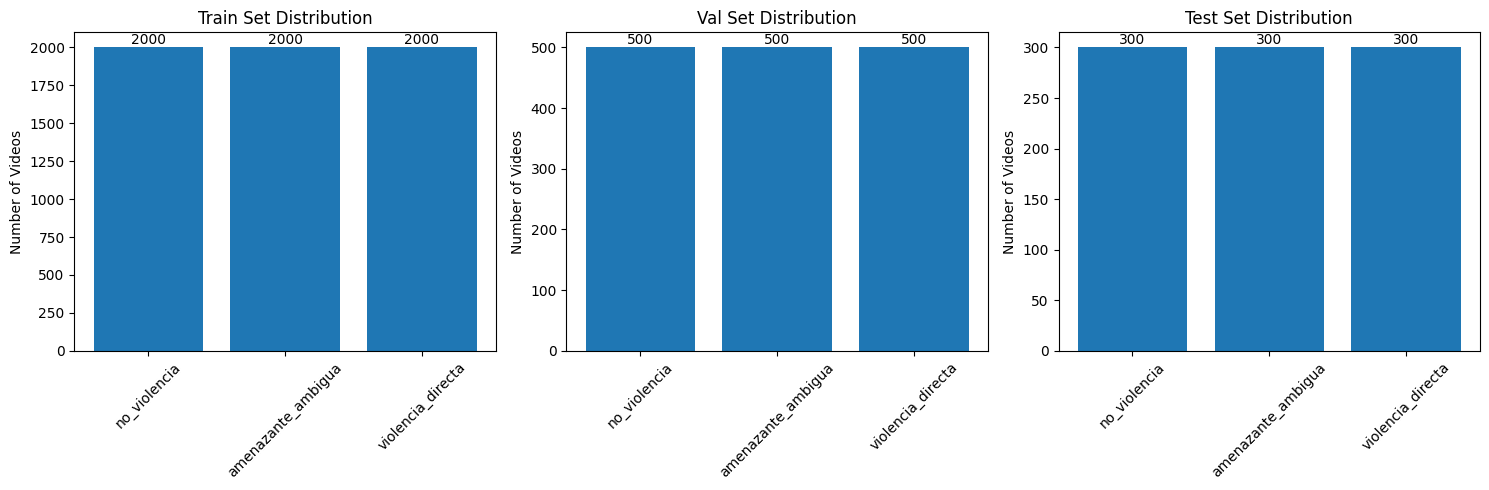

In [15]:
# Analizar dataset y obtener pesos
dataset_stats, class_weights = analyze_dataset(DATASET_PATH)

# Calcular métricas
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    report = classification_report(labels, predictions, output_dict=True)
    conf_matrix = confusion_matrix(labels, predictions)

    # Calcular especificidad
    specificity = []
    for i in range(NUM_CLASSES):
        tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
        fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # Calcular Top-5 Accuracy
    top5_acc = np.mean([1 if labels[i] in np.argsort(-predictions[i])[:5] else 0 for i in range(len(labels))])

    return {
        'accuracy': report['accuracy'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1': report['macro avg']['f1-score'],
        'specificity': np.mean(specificity),
        'top5_accuracy': top5_acc
    }

# Visualizar Grad-CAM
def visualize_gradcam(model, frames, target_class, save_path):
    target_layers = [model.timesformer.encoder.layer[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    frames_input = frames.unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=frames_input, targets=[target_class])

    frames_np = frames.cpu().numpy().transpose(1, 2, 3, 0)
    frames_np = frames_np / frames_np.max()
    cam_image = show_cam_on_image(frames_np[0], grayscale_cam[0], use_rgb=True)

    plt.figure(figsize=(8, 6))
    plt.imshow(cam_image)
    plt.title(f'Grad-CAM for {CLASS_NAMES[target_class]}')
    plt.axis('off')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

# Medir latencia
def measure_latency(model, device, num_frames=8, num_trials=10):
    model.eval()
    dummy_input = torch.randn(1, 3, num_frames, 224, 224).to(device)
    latencies = []

    for _ in range(num_trials):
        start_time = time.time()
        with torch.no_grad():
            model(dummy_input)
        latencies.append(time.time() - start_time)

    avg_latency = np.mean(latencies)
    fps = 1.0 / avg_latency
    print(f"Average Latency: {avg_latency:.3f} seconds")
    print(f"FPS: {fps:.2f}")
    return avg_latency, fps

# Exportar a ONNX
def export_to_onnx(model, output_path, num_frames=8):
    model.eval()
    dummy_input = torch.randn(1, 3, num_frames, 224, 224).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        output_path,
        opset_version=12,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    print(f"Model exported to {output_path}")

# **3. Transfer Learning (Fase 1)**

In [27]:
from transformers import TrainerCallback

# Transfer Learning Phase
def transfer_learning_phase():
    """Fase 1: Transfer Learning con capas superiores congeladas"""

    # Configurar la clave API de WandB
    try:
        with open('/content/drive/MyDrive/Proyecto IA-3/violence_school_project/wandb_api_key.txt', 'r') as f:
            os.environ["WANDB_API_KEY"] = f.read().strip()
    except FileNotFoundError:
        print("Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo (no recomendado para código compartido).")
        os.environ["WANDB_API_KEY"] = "30a7a34eb742653f47d9208966cbed1dc6f31e2d"

    # Inicializar WandB
    wandb.init(
        project="violence-detection-timesformer",
        name=f"transfer_learning_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        config={
            "phase": "transfer_learning",
            "model": MODEL_NAME,
            "num_frames": NUM_FRAMES,
            "batch_size": 4,
            "learning_rate": 5e-5,
            "epochs": 20,
        }
    )

    # Congelar todas las capas excepto el clasificador
    for param in model.timesformer.parameters():
        param.requires_grad = False

    # Asegurarse de que el clasificador esté descongelado
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Configuración de entrenamiento
    training_args = TrainingArguments(
        output_dir=f"{CHECKPOINTS_PATH}/transfer_learning",
        num_train_epochs=20,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f"{LOGGS_PATH}/transfer_learning",  # Corregido: LOGGS_PATH a LOGS_PATH
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        save_total_limit=3,
        report_to="wandb",
        learning_rate=5e-5,
        fp16=True,  # Mixed precision training
        gradient_accumulation_steps=4,  # Simular batch más grande
        eval_accumulation_steps=1,
    )

    # Callback personalizado para imprimir métricas por época
    class PrintMetricsCallback(TrainerCallback):
        """Callback para imprimir métricas después de cada época"""

        def on_epoch_end(self, args, state, control, **kwargs):
            # Obtener métricas del estado actual
            if state.log_history:
                # Buscar las métricas más recientes
                current_epoch = state.epoch
                latest_metrics = {}

                # Recorrer el historial en reversa para encontrar las métricas más recientes
                for log_entry in reversed(state.log_history):
                    if 'epoch' in log_entry and log_entry['epoch'] == int(current_epoch):
                        if 'loss' in log_entry:
                            latest_metrics['train_loss'] = log_entry['loss']
                        if 'eval_loss' in log_entry:
                            latest_metrics['eval_loss'] = log_entry['eval_loss']
                            latest_metrics['eval_accuracy'] = log_entry.get('eval_accuracy', 0)
                            latest_metrics['eval_f1'] = log_entry.get('eval_f1', 0)
                            latest_metrics['eval_precision'] = log_entry.get('eval_precision', 0)
                            latest_metrics['eval_recall'] = log_entry.get('eval_recall', 0)
                            break

                # Imprimir métricas formateadas
                print(f"\n{'='*50}")
                print(f"Época {int(current_epoch)}/{args.num_train_epochs}")
                print(f"{'='*50}")
                if 'train_loss' in latest_metrics:
                    print(f"  Pérdida de entrenamiento: {latest_metrics['train_loss']:.4f}")
                if 'eval_loss' in latest_metrics:
                    print(f"  Pérdida de validación: {latest_metrics['eval_loss']:.4f}")
                    print(f"  Accuracy: {latest_metrics['eval_accuracy']:.4f}")
                    print(f"  F1-Score: {latest_metrics['eval_f1']:.4f}")
                    print(f"  Precisión: {latest_metrics['eval_precision']:.4f}")
                    print(f"  Recall: {latest_metrics['eval_recall']:.4f}")
                print(f"{'='*50}\n")

    # Crear Trainer con el callback personalizado
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=3),
            PrintMetricsCallback()  # Agregar nuestro callback personalizado
        ],
    )

    # Entrenar
    print("Iniciando entrenamiento...")
    print(f"Total de épocas: {training_args.num_train_epochs}")
    print(f"Tamaño del batch: {training_args.per_device_train_batch_size}")
    print(f"Learning rate: {training_args.learning_rate}")
    print(f"Capas congeladas: Todas excepto el clasificador")
    print("\n")

    trainer.train()

    # Guardar modelo
    model.save_pretrained(f"{MODELS_PATH}/transfer_learning_model")
    processor.save_pretrained(f"{MODELS_PATH}/transfer_learning_model")

    # Evaluar
    eval_results = trainer.evaluate()

    # Imprimir resultados finales
    print("\n" + "="*50)
    print("RESULTADOS FINALES - TRANSFER LEARNING")
    print("="*50)
    print(f"Pérdida de evaluación: {eval_results['eval_loss']:.4f}")
    print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"F1-Score: {eval_results['eval_f1']:.4f}")
    print(f"Precisión: {eval_results['eval_precision']:.4f}")
    print(f"Recall: {eval_results['eval_recall']:.4f}")
    print("="*50)

    # Guardar resultados en archivo JSON
    with open(f"{RESULTS_PATH}/transfer_learning_metrics.json", 'w') as f:
        json.dump(eval_results, f, indent=4)

    wandb.finish()

    return trainer, eval_results

In [ ]:
from transformers import TrainerCallback

# Transfer Learning Phase
def transfer_learning_phase():
    """Fase 1: Transfer Learning con capas superiores congeladas"""

    # Configurar la clave API de WandB
    try:
        with open('/content/drive/MyDrive/Proyecto IA-3/violence_school_project/wandb_api_key.txt', 'r') as f:
            os.environ["WANDB_API_KEY"] = f.read().strip()
    except FileNotFoundError:
        print("Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo (no recomendado para código compartido).")
        os.environ["WANDB_API_KEY"] = "30a7a34eb742653f47d9208966cbed1dc6f31e2d"

    # Inicializar WandB
    wandb.init(
        project="violence-detection-timesformer",
        name=f"transfer_learning_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        config={
            "phase": "transfer_learning",
            "model": MODEL_NAME,
            "num_frames": NUM_FRAMES,
            "batch_size": 8,  # Aumentado para mejor rendimiento
            "learning_rate": 5e-5,
            "epochs": 20,
        }
    )

    # Congelar todas las capas excepto el clasificador
    for param in model.timesformer.parameters():
        param.requires_grad = False

    # Asegurarse de que el clasificador esté descongelado
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Configuración de entrenamiento optimizada
    training_args = TrainingArguments(
        output_dir=f"{CHECKPOINTS_PATH}/transfer_learning",
        num_train_epochs=20,
        per_device_train_batch_size=8,  # Aumentado de 4 a 8
        per_device_eval_batch_size=16,  # Aumentado para evaluación más rápida
        warmup_steps=100,  # Reducido de 500 a 100
        weight_decay=0.01,
        logging_dir=f"{LOGS_PATH}/transfer_learning",
        logging_steps=50,  # Reducido la frecuencia de logging
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=5,  # Mantener solo los mejores checkpoints
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        report_to="wandb",
        learning_rate=5e-5,
        fp16=True,  # Mixed precision training
        gradient_accumulation_steps=2,  # Reducido de 4 a 2 para más actualizaciones
        eval_accumulation_steps=1,
        dataloader_num_workers=4,  # Paralelizar carga de datos
        dataloader_pin_memory=True,  # Memoria fijada para mejor rendimiento
        gradient_checkpointing=False,  # Desactivado para transfer learning
        auto_find_batch_size=False,  # Usar batch size fijo
        ddp_find_unused_parameters=False,  # Optimización para DDP
    )

    # Callback personalizado para imprimir métricas por época
    class PrintMetricsCallback(TrainerCallback):
        """Callback para imprimir métricas después de cada época"""

        def on_epoch_end(self, args, state, control, **kwargs):
            # Obtener métricas del estado actual
            if state.log_history:
                # Buscar las métricas más recientes
                current_epoch = int(state.epoch)
                latest_metrics = {}

                # Recorrer el historial en reversa para encontrar las métricas más recientes
                for log_entry in reversed(state.log_history):
                    if 'epoch' in log_entry and int(log_entry['epoch']) == current_epoch:
                        if 'loss' in log_entry:
                            latest_metrics['train_loss'] = log_entry['loss']
                        if 'eval_loss' in log_entry:
                            latest_metrics['eval_loss'] = log_entry['eval_loss']
                            latest_metrics['eval_accuracy'] = log_entry.get('eval_accuracy', 0)
                            latest_metrics['eval_f1'] = log_entry.get('eval_f1', 0)
                            latest_metrics['eval_precision'] = log_entry.get('eval_precision', 0)
                            latest_metrics['eval_recall'] = log_entry.get('eval_recall', 0)
                            break

                # Imprimir métricas formateadas
                print(f"\n{'='*50}")
                print(f"Época {current_epoch}/{args.num_train_epochs}")
                print(f"{'='*50}")
                if 'train_loss' in latest_metrics:
                    print(f"  Pérdida de entrenamiento: {latest_metrics['train_loss']:.4f}")
                if 'eval_loss' in latest_metrics:
                    print(f"  Pérdida de validación: {latest_metrics['eval_loss']:.4f}")
                    print(f"  Accuracy: {latest_metrics['eval_accuracy']:.4f}")
                    print(f"  F1-Score: {latest_metrics['eval_f1']:.4f}")
                    print(f"  Precisión: {latest_metrics['eval_precision']:.4f}")
                    print(f"  Recall: {latest_metrics['eval_recall']:.4f}")
                print(f"{'='*50}\n")

    # Callback para guardar checkpoints cada 5 épocas
    class SaveEveryNEpochsCallback(TrainerCallback):
        """Callback para guardar el modelo cada N épocas"""

        def __init__(self, save_epochs=5):
            self.save_epochs = save_epochs

        def on_epoch_end(self, args, state, control, **kwargs):
            current_epoch = int(state.epoch)
            if current_epoch % self.save_epochs == 0:
                # Guardar el modelo
                output_dir = os.path.join(args.output_dir, f"checkpoint-epoch-{current_epoch}")
                print(f"\n>>> Guardando checkpoint en época {current_epoch} en {output_dir}")

                # Crear directorio si no existe
                os.makedirs(output_dir, exist_ok=True)

                # Guardar el modelo y el procesador
                kwargs['model'].save_pretrained(output_dir)
                if hasattr(kwargs.get('processor', None), 'save_pretrained'):
                    kwargs['processor'].save_pretrained(output_dir)

                # Guardar el estado del trainer
                trainer_state_file = os.path.join(output_dir, "trainer_state.json")
                state_dict = state.__dict__.copy()
                # Convertir valores no serializables a algo serializable
                for key, value in state_dict.items():
                    if isinstance(value, float) and (math.isnan(value) or math.isinf(value)):
                        state_dict[key] = str(value)
                with open(trainer_state_file, 'w') as f:
                    json.dump(state_dict, f, indent=2)

                print(f">>> Checkpoint guardado exitosamente")

    # Crear Trainer con los callbacks personalizados
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=3),
            PrintMetricsCallback(),
            SaveEveryNEpochsCallback(save_epochs=5)  # Guardar cada 5 épocas
        ],
    )

    # Entrenar
    print("Iniciando entrenamiento optimizado...")
    print(f"Total de épocas: {training_args.num_train_epochs}")
    print(f"Tamaño del batch: {training_args.per_device_train_batch_size}")
    print(f"Learning rate: {training_args.learning_rate}")
    print(f"Capas congeladas: Todas excepto el clasificador")
    print(f"Workers para DataLoader: {training_args.dataloader_num_workers}")
    print(f"Mixed Precision (FP16): {training_args.fp16}")
    print(f"Checkpoints se guardarán cada 5 épocas")
    print("\n")

    # Iniciar entrenamiento
    trainer.train()

    # Guardar modelo final
    model.save_pretrained(f"{MODELS_PATH}/transfer_learning_model")
    processor.save_pretrained(f"{MODELS_PATH}/transfer_learning_model")

    # Evaluar
    eval_results = trainer.evaluate()

    # Imprimir resultados finales
    print("\n" + "="*50)
    print("RESULTADOS FINALES - TRANSFER LEARNING")
    print("="*50)
    print(f"Pérdida de evaluación: {eval_results['eval_loss']:.4f}")
    print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"F1-Score: {eval_results['eval_f1']:.4f}")
    print(f"Precisión: {eval_results['eval_precision']:.4f}")
    print(f"Recall: {eval_results['eval_recall']:.4f}")
    print("="*50)

    # Listar checkpoints guardados
    print("\nCheckpoints guardados:")
    checkpoint_dirs = glob.glob(f"{CHECKPOINTS_PATH}/transfer_learning/checkpoint-epoch-*")
    for checkpoint_dir in sorted(checkpoint_dirs):
        print(f"  - {checkpoint_dir}")

    # Guardar resultados en archivo JSON
    with open(f"{RESULTS_PATH}/transfer_learning_metrics.json", 'w') as f:
        json.dump(eval_results, f, indent=4)

    wandb.finish()

    return trainer, eval_results


# **4. Fine-tuning (Fase 2)**

In [17]:
# Fine-tuning Phase
def fine_tuning_phase(model_path):
    """Fase 2: Fine-tuning con todo el modelo descongelado"""

    # Cargar modelo de transfer learning
    model = TimesformerForVideoClassification.from_pretrained(model_path)
    model = model.to(device)

    # Descongelar gradualmente las capas
    # Primero, descongelar las últimas capas del encoder
    for param in model.parameters():
        param.requires_grad = True

    # Inicializar WandB
    wandb.init(
        project="violence-detection-timesformer",
        name=f"fine_tuning_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        config={
            "phase": "fine_tuning",
            "model": MODEL_NAME,
            "num_frames": NUM_FRAMES,
            "batch_size": 4,
            "learning_rate": 1e-5,
            "epochs": 30,
        }
    )

    # Configuración de entrenamiento para fine-tuning
    training_args = TrainingArguments(
        output_dir=f"{CHECKPOINTS_PATH}/fine_tuning",
        num_train_epochs=30,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_ratio=0.1,
        weight_decay=0.01,
        logging_dir=f"{LOGS_PATH}/fine_tuning",
        logging_steps=10,
        eval_strategy="epoch",  # Cambiado de evaluation_strategy a eval_strategy
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        save_total_limit=3,
        report_to="wandb",
        learning_rate=1e-5,  # Learning rate más bajo para fine-tuning
        fp16=True,
        gradient_accumulation_steps=4,
        lr_scheduler_type="cosine",  # Cosine learning rate schedule
    )

    # Crear Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    # Entrenar
    trainer.train()

    # Guardar modelo final
    model.save_pretrained(f"{MODELS_PATH}/final_model")
    processor.save_pretrained(f"{MODELS_PATH}/final_model")

    # Evaluar
    eval_results = trainer.evaluate()

    wandb.finish()

    return trainer, eval_results

# **5. Evaluación Completa y Métricas**

In [21]:
# Evaluación en test set
def evaluate_on_test_set(trainer):
    test_results = trainer.predict(test_dataset)
    predictions = np.argmax(test_results.predictions, axis=1)
    true_labels = test_results.label_ids

    report = classification_report(true_labels, predictions, target_names=CLASS_NAMES, output_dict=True)
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Visualizar matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{RESULTS_PATH}/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Curvas ROC
    y_true_bin = label_binarize(true_labels, classes=range(NUM_CLASSES))
    y_pred_proba = test_results.predictions

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10, 8))
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.3f})')
        wandb.log({f"roc_auc_{CLASS_NAMES[i]}": roc_auc[i]})

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Multi-class')
    plt.legend(loc="lower right")
    plt.savefig(f'{RESULTS_PATH}/roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Precision-Recall
    plt.figure(figsize=(10, 8))
    for i in range(NUM_CLASSES):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
        avg_precision = np.mean(precision)
        plt.plot(recall, precision, label=f'{CLASS_NAMES[i]} (AP = {avg_precision:.3f})')
        wandb.log({f"avg_precision_{CLASS_NAMES[i]}": avg_precision})

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="lower left")
    plt.savefig(f'{RESULTS_PATH}/precision_recall_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    return report, conf_matrix

# Visualizar métricas de entrenamiento
def plot_training_metrics(trainer):
    train_history = trainer.state.log_history
    train_loss = []
    eval_loss = []
    eval_accuracy = []
    eval_f1 = []
    eval_specificity = []
    epochs = []

    for entry in train_history:
        if 'loss' in entry:
            train_loss.append(entry['loss'])
        if 'eval_loss' in entry:
            eval_loss.append(entry['eval_loss'])
            eval_accuracy.append(entry['eval_accuracy'])
            eval_f1.append(entry['eval_f1'])
            eval_specificity.append(entry['eval_specificity'])
            epochs.append(entry['epoch'])

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(train_loss, label='Training Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Steps')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].plot(epochs, eval_loss, 'o-', label='Validation Loss')
    axes[0, 1].set_title('Validation Loss')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[1, 0].plot(epochs, eval_accuracy, 'o-', label='Validation Accuracy')
    axes[1, 0].set_title('Validation Accuracy')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    axes[1, 1].plot(epochs, eval_f1, 'o-', label='Validation F1')
    axes[1, 1].set_title('Validation F1 Score')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig(f'{RESULTS_PATH}/training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Analizar errores
def analyze_errors(trainer, dataset):
    predictions = trainer.predict(dataset)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    errors = []
    for i, (pred, true) in enumerate(zip(pred_labels, true_labels)):
        if pred != true:
            errors.append({
                'index': i,
                'true_label': CLASS_NAMES[true],
                'predicted_label': CLASS_NAMES[pred],
                'confidence': predictions.predictions[i][pred]
            })

    errors_df = pd.DataFrame(errors)

    if len(errors_df) > 0:
        plt.figure(figsize=(10, 6))
        error_counts = errors_df.groupby(['true_label', 'predicted_label']).size().unstack(fill_value=0)
        sns.heatmap(error_counts, annot=True, fmt='d', cmap='Reds')
        plt.title('Error Distribution Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f'{RESULTS_PATH}/error_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

    return errors_df

# Generar reporte final
def generate_final_report(transfer_results, finetune_results, test_report):
    report = f"""
# TimeSformer Violence Detection - Training Report
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Information
- Base Model: {MODEL_NAME}
- Number of Classes: {NUM_CLASSES}
- Classes: {', '.join(CLASS_NAMES)}
- Input Frames: {NUM_FRAMES}
- Frame Size: 224x224
- Attention Heads: {model.config.num_attention_heads}
- Classifier: Linear with Dropout (0.3)

## Training Process

### Phase 1: Transfer Learning
- Epochs: 20
- Learning Rate: 5e-5
- Frozen Layers: All except classifier
- Optimizer: AdamW
- Final Metrics:
  - Loss: {transfer_results['eval_loss']:.4f}
  - Accuracy: {transfer_results['eval_accuracy']:.4f}
  - F1 Score: {transfer_results['eval_f1']:.4f}
  - Specificity: {transfer_results['eval_specificity']:.4f}
  - Top-5 Accuracy: {transfer_results['eval_top5_accuracy']:.4f}

### Phase 2: Fine-tuning
- Epochs: 30
- Learning Rate: 1e-5
- Frozen Layers: None
- Optimizer: AdamW
- Final Metrics:
  - Loss: {finetune_results['eval_loss']:.4f}
  - Accuracy: {finetune_results['eval_accuracy']:.4f}
  - F1 Score: {finetune_results['eval_f1']:.4f}
  - Specificity: {finetune_results['eval_specificity']:.4f}
  - Top-5 Accuracy: {finetune_results['eval_top5_accuracy']:.4f}

## Test Set Evaluation

### Overall Metrics
- Accuracy: {test_report['accuracy']:.4f}
- Macro Precision: {test_report['macro avg']['precision']:.4f}
- Macro Recall: {test_report['macro avg']['recall']:.4f}
- Macro F1-Score: {test_report['macro avg']['f1-score']:.4f}
- Macro Specificity: {np.mean([test_report[cls]['specificity'] for cls in CLASS_NAMES]):.4f}
- Top-5 Accuracy: {test_report['top5_accuracy']:.4f}

### Per-Class Metrics
"""

    for class_name in CLASS_NAMES:
        metrics = test_report[class_name]
        report += f"""
#### {class_name}
- Precision: {metrics['precision']:.4f}
- Recall: {metrics['recall']:.4f}
- F1-Score: {metrics['f1-score']:.4f}
- Specificity: {metrics.get('specificity', 0.0):.4f}
- Support: {metrics['support']}
"""

    report += f"""
## Model Files
- Final Model: {MODELS_PATH}/final_model
- Transfer Learning Model: {MODELS_PATH}/transfer_learning_model
- ONNX Model: {MODELS_PATH}/timesformer_final.onnx
"""

    report_path = f'{RESULTS_PATH}/final_training_report.md'
    with open(report_path, 'w') as f:
        f.write(report)

    print(f"Report saved to: {report_path}")
    return report

# Inferencia para pruebas
def predict_video(video_path, model, processor, device):
    temp_dataset = ViolenceVideoDataset(
        root_dir=os.path.dirname(os.path.dirname(video_path)),
        split=os.path.basename(os.path.dirname(video_path)),
        num_frames=NUM_FRAMES
    )

    video_idx = None
    for i, path in enumerate(temp_dataset.video_paths):
        if path == video_path:
            video_idx = i
            break

    if video_idx is None:
        raise ValueError(f"Video not found: {video_path}")

    frames, true_label = temp_dataset[video_idx]
    if frames is None:
        raise ValueError(f"Failed to load video: {video_path}")

    processed_frames = preprocess_video(frames, processor)
    processed_frames = processed_frames.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(processed_frames)
        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    return {
        'predicted_class': CLASS_NAMES[predicted_class],
        'true_class': CLASS_NAMES[true_label],
        'probabilities': {CLASS_NAMES[i]: prob.item() for i, prob in enumerate(probabilities[0])},
        'correct': predicted_class == true_label
    }


# **ENTRENAMIENTO**

In [ ]:
# Ejecutar entrenamiento
print("Starting Transfer Learning phase...")
transfer_trainer, transfer_results = transfer_learning_phase()

Starting Transfer Learning phase...


Iniciando entrenamiento...
Total de épocas: 20
Tamaño del batch: 4
Learning rate: 5e-05
Capas congeladas: Todas excepto el clasificador




Epoch,Training Loss,Validation Loss


In [ ]:

print("\nStarting Fine-tuning phase...")
finetune_trainer, finetune_results = fine_tuning_phase(f"{MODELS_PATH}/transfer_learning_model")

print("\nEvaluating final model on test set...")
test_report, conf_matrix = evaluate_on_test_set(finetune_trainer)

print("\nAnalyzing prediction errors...")
errors_df = analyze_errors(finetune_trainer, test_dataset)
print(f"Total errors: {len(errors_df)}")
print(f"Error rate: {len(errors_df)/len(test_dataset)*100:.2f}%")

print("\nVisualizing training metrics...")
plot_training_metrics(finetune_trainer)

print("\nGenerating final report...")
final_report = generate_final_report(transfer_results, finetune_results, test_report)
print("\n" + final_report)

# Probar con videos de test
test_video_dir = Path(DATASET_PATH) / 'test'
sample_videos = []
for class_name in CLASS_NAMES:
    class_videos = list((test_video_dir / class_name).glob('*.mp4'))
    if class_videos:
        sample_videos.append(random.choice(class_videos))

print("\nTesting model on sample videos:")
for video_path in sample_videos:
    result = predict_video(str(video_path), model, processor, device)
    print(f"\nVideo: {video_path.name}")
    print(f"True class: {result['true_class']}")
    print(f"Predicted class: {result['predicted_class']}")
    print(f"Correct: {result['correct']}")
    print("Probabilities:")
    for class_name, prob in result['probabilities'].items():
        print(f"  {class_name}: {prob:.4f}")

# Guardar información de despliegue
deployment_info = {
    'model_name': MODEL_NAME,
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'num_frames': NUM_FRAMES,
    'frame_size': 224,
    'attention_heads': model.config.num_attention_heads,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_metrics': {
        'accuracy': test_report['accuracy'],
        'macro_f1': test_report['macro avg']['f1-score'],
        'macro_specificity': np.mean([test_report[cls]['specificity'] for cls in CLASS_NAMES]),
        'top5_accuracy': test_report['top5_accuracy'],
        'per_class_f1': {class_name: test_report[class_name]['f1-score']
                        for class_name in CLASS_NAMES}
    }
}

with open(f'{MODELS_PATH}/deployment_info.json', 'w') as f:
    json.dump(deployment_info, f, indent=4)

print("\n¡Entrenamiento completado exitosamente!")
print(f"Modelo final guardado en: {MODELS_PATH}/final_model")
print(f"ONNX model saved in: {MODELS_PATH}/timesformer_final.onnx")